# Bulldozer Price Prediction Project

### 1. Goal

##### - The goal of this project is to create a model that will accurately predict the sale price of a bulldozer based on various features.

### 2. Data

##### - The dataset used for this data can be found here https://www.kaggle.com/c/bluebook-for-bulldozers/data
##### - A data dictionary has been provided and can be found here https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit#gid=1021421956

### 3. Evaluation

##### - The the main metric of evaluation for this project is RMSLE (root mean squared log error) between the actual and predicted sale price, as that is the requested metric. However, we may also use other metrics for evaluation such as r-squared

In [1]:
# Import statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import data
df = pd.read_csv('TrainAndValid.csv', low_memory = False)

In [4]:
# Preview data
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Let's now conduct some EDA

- From inital glance, it appears that we have a good amount of nulls in come columns
- We also want to take a look at our datatypes. It appears that some columns are datetime datatypes
- We also will want to visualize some of the data to check correlations, counts of categories, distributions, and more

#### Let's take a look at the missing data in out dataset, easiest to do this as a percent

In [5]:
# Get percent of each column that is null

df.isna().sum()/len(df)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
saledate                     0.000000
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission

#### We have quite a few columns that have a large amount of nulls, this is something we definitely need to address.

### Let's now take a look at the datatypes of our columns

In [6]:
# Get data types

df.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
saledate                     object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                

#### - We can see most of our data is categorical, we will need to convert this to numeric / encoded in order to use most models, including linear regression

#### - The saledate column also appears to be formatted as a datetime. We will likely want to change this to a datetime dtype

In [7]:
df_copy = df.copy()

In [8]:
# Let's convert the saledate column to a datetime and create a few features based off this

df_copy['saledate'] = pd.to_datetime(df['saledate'])

In [9]:
# Validate

df_copy['saledate'].dtypes

dtype('<M8[ns]')

In [10]:
# Let's now take a look at how sale price has varied year over year

# Create new columns for sale year and month
df_copy['saleyear'] = df_copy['saledate'].dt.year
df_copy['salemonth'] = df_copy['saledate'].dt.month

# First calculate sale price for each year and month
median_sale_price_year = df_copy.groupby(['saleyear'])['SalePrice'].median()
median_sale_price_year

saleyear
1989    21000.0
1990    22500.0
1991    23000.0
1992    21000.0
1993    22500.0
1994    23000.0
1995    21000.0
1996    23000.0
1997    23000.0
1998    24500.0
1999    24000.0
2000    24000.0
2001    23000.0
2002    22500.0
2003    22000.0
2004    23000.0
2005    24000.0
2006    26000.0
2007    26000.0
2008    26000.0
2009    22000.0
2010    23500.0
2011    26000.0
2012    27000.0
Name: SalePrice, dtype: float64

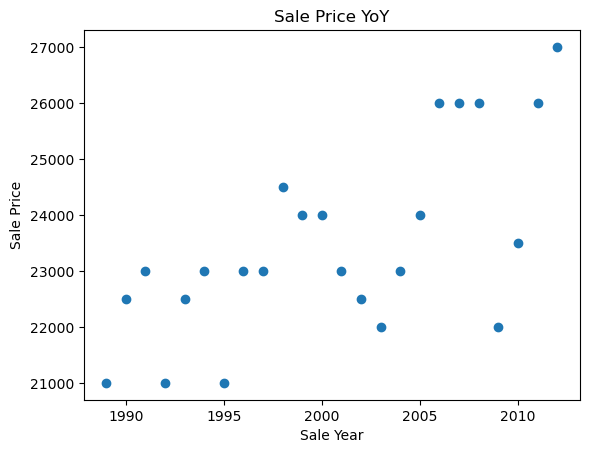

In [11]:
# Plot scatterplot to show how prices varies MoM

plt.scatter(x = median_sale_price_year.index, y = median_sale_price_year.values)
plt.title('Sale Price YoY')
plt.ylabel('Sale Price')
plt.xlabel('Sale Year');

#### Sale prices generally trended upwards over the years. 
    - We see a large drop in price in 2008 & 2009. This could potentially be explained by the recession that went on during those years

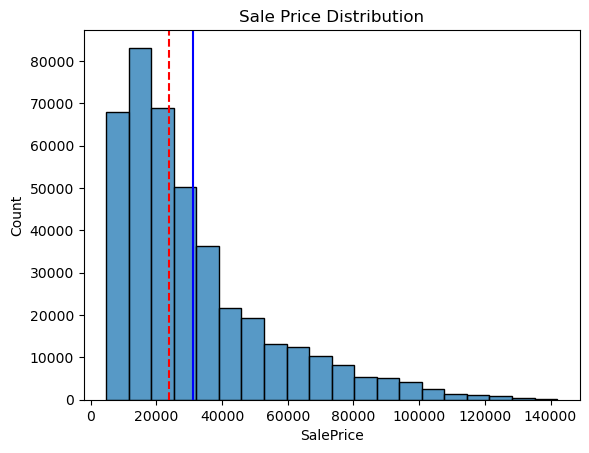

In [12]:
# Let's now take a look at the distribution of sale prices

ax = sns.histplot(df_copy['SalePrice'],
            bins = 20,);

# Add ref line for median
ax.axvline(x = df_copy['SalePrice'].median(), color = 'red', linestyle = 'dashed')
# Add ref line for mean
ax.axvline(x = df_copy['SalePrice'].mean(), color = 'blue', linestyle = 'solid')
# Create title
plt.title('Sale Price Distribution');

#### Our histogram has heavy right skew 

Thus, indicating that we have a higher frequency of lower prices and may have some outliers in our data. This may be something to look further into

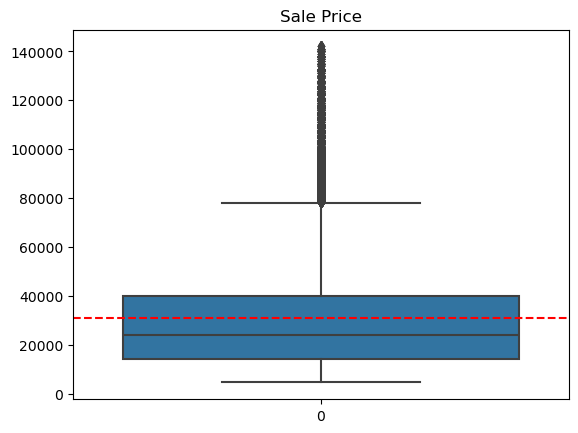

In [13]:
# We can use a box & whisker plot to further inspect the overall sale price

ax = sns.boxplot(data = df_copy['SalePrice'])
# Create a reference line for the mean of the sale price
ax.axhline(df_copy['SalePrice'].mean(), color = 'red', linestyle = 'dashed')
# Create title
plt.title('Sale Price');

This boxplot indicates that we have quite a few 'outliers' that are well above the theoretical max of our plot 
- Theoretical max is calulcated by 1.5 x (Q3 - Q1) + Q3

#### Let's now inspect how the sale price differs with year made

Normally, we would expect the newer models to sell for more. Let's see if this holds true

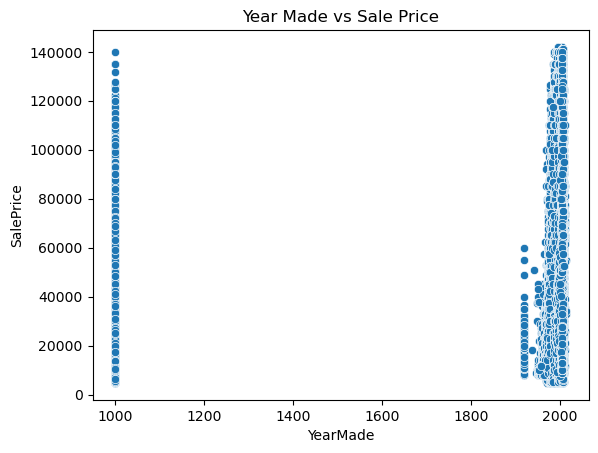

In [14]:
# Create a scatterplot to check correlation

sns.scatterplot(data = df_copy, x = df_copy['YearMade'], y = df_copy['SalePrice'])
plt.title('Year Made vs Sale Price');

#### From the looks of this scatterplot it seems as though we have some inaccurate data in the YearMade column and this is defitely something that should be looked into...
Highly unlikely we have bulldozers made in 1000 still in circulation

In [15]:
# Let's further inspect this
df_copy.YearMade.min()

1000

In [16]:
# Check percent of values that are 1000
len(df_copy[df_copy['YearMade'] == 1000]) / len(df_copy)

0.0954475185244416

<Axes: xlabel='YearMade'>

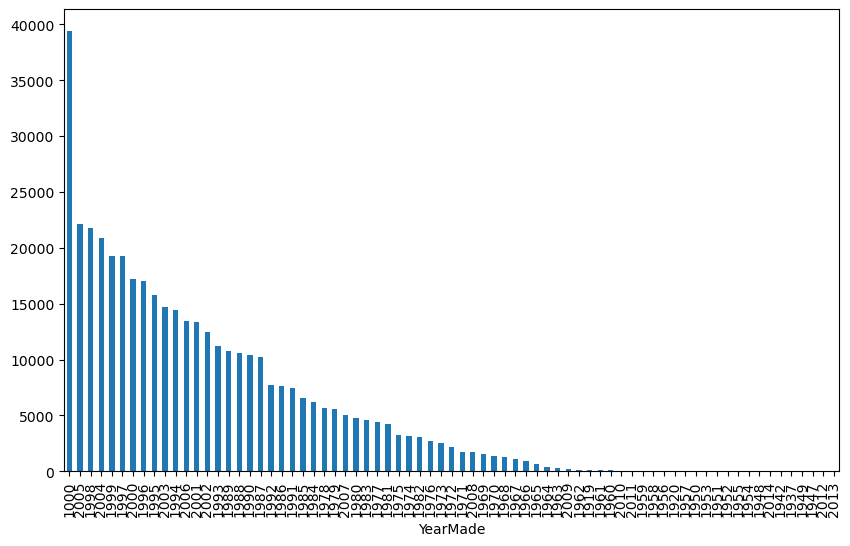

In [17]:
# My initial though is that these 1000 values are actually supposed to be 2000. 
# Let's check the distribution of YearMade column to see if we can get further insight

fig,ax = plt.subplots(figsize = (10,6))
df_copy['YearMade'].value_counts().plot(kind = 'bar')

##### Based on my initial thoughts I would have expected to see a large drop off in the count of '2000' values in the YearMade column. Since the amount of rows containing '2000' for YearMade seems to be pretty on par with the rest of the YearMade values this is likely not the case. 

##### Let's not try to take a look at the modelIDs of the bulldozers that were made in 1000 and see if that gives us any info into when they might actually have been made

In [18]:
# Take a look at the model IDs of the dozers that were made in 1000
df_copy.loc[df_copy['YearMade'] == 1000]['ModelID'].value_counts()

ModelID
9550     490
3170     413
11587    378
8724     354
5561     297
        ... 
16223      1
16295      1
5195       1
26250      1
19338      1
Name: count, Length: 3431, dtype: int64

#### We will try and do is use the distribution of the years of which these IDs were made in to replace the inaccurate 1000 values in YearMade

We will then likely drop all the other rows that we cannot impute

In [19]:
# Take top 10 value counts from the above
innacurate_model_ids = df_copy.loc[df_copy['YearMade'] == 1000]['ModelID'].value_counts().index[:10]

In [20]:
# Create a dictionary we will use for mapping the ModelIDs to a new year
distribution_dict = {}

for model_id in innacurate_model_ids:
    non_1000_years = df_copy[(df_copy['ModelID'] == model_id) & (df['YearMade'] != 1000)]['YearMade']
    distribution_dict[model_id] = non_1000_years

In [21]:
# Reaplce YearMade values with random samples from the corresponing distribution
for index, row in df_copy.iterrows():
    if row['YearMade'] == 1000:
        model_id = row['ModelID']
        if model_id in distribution_dict:
            new_year = np.random.choice(distribution_dict[model_id])
            df_copy.at[index, 'YearMade'] = new_year

In [22]:
# Check counts of YearMade column again
df_copy['YearMade'].value_counts()

YearMade
1000    36272
2005    22103
1998    21887
2004    20921
1997    19439
        ...  
1937        1
1949        1
1947        1
2012        1
2013        1
Name: count, Length: 73, dtype: int64

In [23]:
# Let's now recheck how many rows have YearMade == 1000 in the df_copy dataset
len(df_copy[df_copy['YearMade'] == 1000]) / len(df_copy)

0.08788993404378019

##### By doing this we decreased the the amount of rows 1000 as the YearMade value by about 8%. We may consider dropping the rest of these rows with 1000

In [24]:
# Let's check some other columns to see if they also have similar issues
df_copy.select_dtypes(include = ['number']).min()

SalesID                     1139246.0
SalePrice                      4750.0
MachineID                         0.0
ModelID                          28.0
datasource                      121.0
auctioneerID                      0.0
YearMade                       1000.0
MachineHoursCurrentMeter          0.0
saleyear                       1989.0
salemonth                         1.0
dtype: float64

##### Other columns seem to be good at first glance

### Next steps

- Simple linear regression on a continuous variable ( maybe sale year ) ✅
   - Conduct regression test with, and without cleaning the remaining '1000' values in YearMade column to see if cleaning increases        predictive power
- Drop/impute nulls
   - they filled numerics with median in vids
   - they filled categorical with cat codes + 1 (since missing is -1)
- check for any crazy outliers in numeric cols
    - boxplots
- Correlation (heat map)
- ANOVA on a categorical


### Let's now conduct simple linear regression using the sale year that we have cleaned up. 

- We will try two forms of this
  1. Including the remaining '1000' YearMade values that we have not cleaned
  2. Dropping the remaining '1000' YearMade values that we have not cleaned

In [25]:
# Create a df of YearMade and SalePrice from df_copy
lin_reg_uncleaned = df_copy[['YearMade','SalePrice']]
len(lin_reg_uncleaned)

412698

In [26]:
# Split into X (independant variable) and y (dependant variable)
X = pd.DataFrame(lin_reg_uncleaned['YearMade'])
y = lin_reg_uncleaned['SalePrice']

In [27]:
# Import linear regression
from sklearn.linear_model import LinearRegression

# Instantiate model
lr_model = LinearRegression()
lr_model.fit(X, y)

# Check coefficient and intercept
print("Coefficient:", lr_model.coef_)
print("Intercept:", lr_model.intercept_)

# Get R-squared metric
r_squared = lr_model.score(X,y)
print("R-squared:", r_squared)

Coefficient: [12.04508759]
Intercept: 8250.712709462176
R-squared: 0.021476510432047236


In [28]:
# Let's now see if dropping the YearMade values of 1000 make any dfference
lin_reg_cleaned = df_copy[['YearMade','SalePrice']]

In [29]:
# Drop rows where YearMade == 1000
lin_reg_cleaned.drop(lin_reg_cleaned.loc[lin_reg_cleaned['YearMade']==1000].index, axis = 0, inplace = True)

In [30]:
# Check length of dataset after dropping
len(lin_reg_cleaned)

376426

In [31]:
# Split data into X and y
X = pd.DataFrame(lin_reg_cleaned['YearMade'])
y = lin_reg_cleaned['SalePrice']

# Fit the model
lr_model.fit(X, y)

# Check r-squared metric
r_squared = lr_model.score(X,y)
print("R-squared:", r_squared)

R-squared: 0.04774317771173364


### Takeaway:
##### We can see YearMade alone does not hold much predictive power. However, we do see the model performed almost twice as well, albeit  still pretty poor, when we drop the '1000' values in the YearMade column

## Let's now work on cleaning up some of our columns with null values

In [32]:
# First let's get a list of all columns that have over 75% null values - we will drop these
cols_with_high_nulls = []
for column in df_copy.columns:
    if df_copy[column].isna().sum()/len(df_copy[column]) > .75:
        cols_with_high_nulls.append(column)
        print(column)

UsageBand
fiModelSeries
fiModelDescriptor
Pad_Type
Stick
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Pushblock
Scarifier
Tip_Control
Tire_Size
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [33]:
# Append sale price since that is what we are ultimately trying to predict
cols_with_high_nulls.append('SalePrice')

#### Before we drop these columns let's take a look at their correlation to the target variable to ensure we are not dropping important columns

In [34]:
# First we need to transform the categorical variables into numeric. We will do so by getting the category codes

for label, content in df_copy[cols_with_high_nulls].items():
    if not pd.api.types.is_numeric_dtype(content):
        df_copy[label] = pd.Categorical(content).codes+1

In [35]:
# Validate dtypes were changed
df_copy[cols_with_high_nulls].dtypes

UsageBand                     int8
fiModelSeries                 int8
fiModelDescriptor            int16
Pad_Type                      int8
Stick                         int8
Turbocharged                  int8
Blade_Extension               int8
Blade_Width                   int8
Enclosure_Type                int8
Engine_Horsepower             int8
Pushblock                     int8
Scarifier                     int8
Tip_Control                   int8
Tire_Size                     int8
Coupler_System                int8
Grouser_Tracks                int8
Hydraulics_Flow               int8
Track_Type                    int8
Undercarriage_Pad_Width       int8
Stick_Length                  int8
Thumb                         int8
Pattern_Changer               int8
Grouser_Type                  int8
Backhoe_Mounting              int8
Blade_Type                    int8
Travel_Controls               int8
Differential_Type             int8
Steering_Controls             int8
SalePrice           

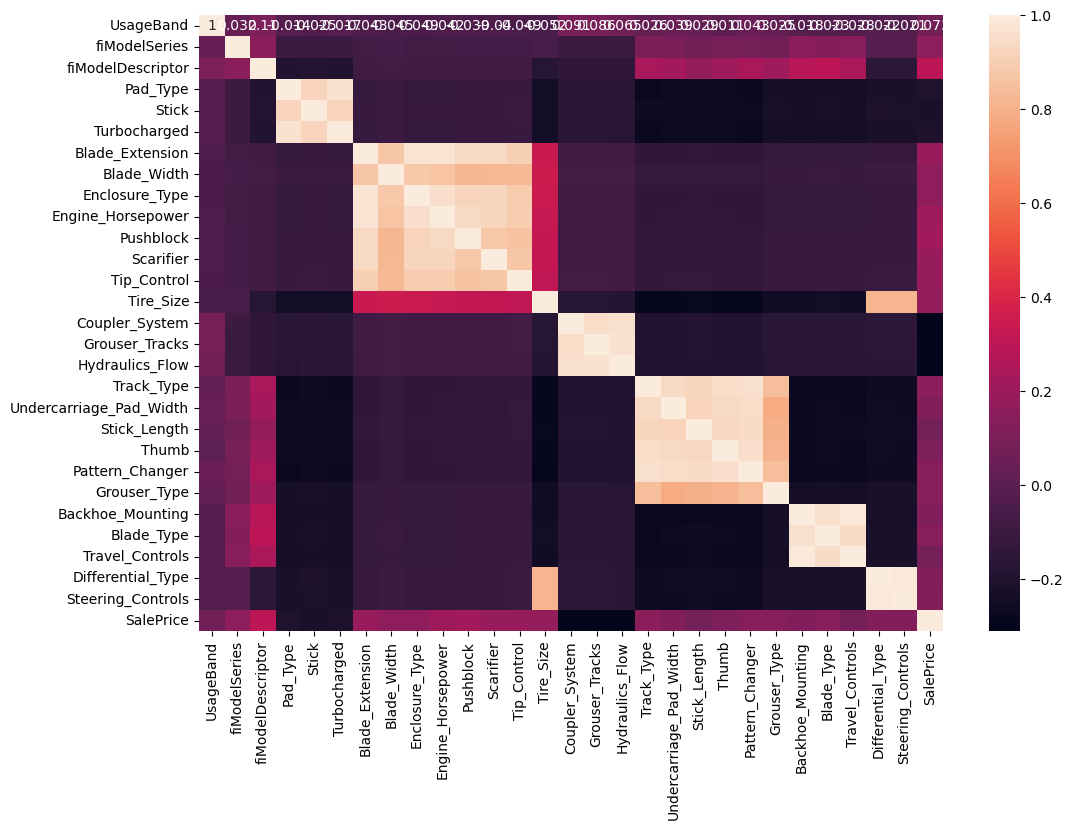

In [36]:
# Create correlation matrix
corr_mat = df_copy[cols_with_high_nulls].corr()

# Plot this using a seaborn heat map
fig, ax = plt.subplots(figsize = (12,8))
ax = sns.heatmap(corr_mat, annot = True )

#### From the looks of the above correlation matrix none of the columns we are considering dropping have much correlation to SalePrice

- This is a good thing as we should be clear to drop without losing much predictive power

In [37]:
# Remove SalePrice from our list of columns to drop
cols_with_high_nulls.pop()

'SalePrice'

In [38]:
# Drop columnss
df_copy.drop(labels = cols_with_high_nulls, axis = 1, inplace = True)

In [39]:
# Validate columns were dropped
df_copy.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Ride_Control', 'Transmission',
       'Hydraulics', 'Ripper', 'Coupler', 'saleyear', 'salemonth'],
      dtype='object')

In [40]:
# Check the percent of values that are null in the columns we have left

df_copy.isna().sum()/len(df_copy)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
saledate                     0.000000
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Ride_Control                62.992794
Transmission                54.444412
Hydraulics                  20.006155
Ripper                      74.086378
Coupler                     46.527727
saleyear                     0.000000
salemonth   

In [41]:
# Let's also drop the Ripper column since it is just about 75% null. 
df_copy.Ripper.value_counts()

Ripper
None or Unspecified    85405
Yes                     8185
Multi Shank             8071
Single Shank            5284
Name: count, dtype: int64

####  Before we delete we will see if this column holds any significant information 
    - to do so we will use an ANOVA test to compare the means of each of the values in this column

In [42]:
# Since None is a reserved key word in Python, let's first change the 'None or Unspecified' value to just unspecified since we will be using the first word for a dataframe title
df_copy.loc[df_copy['Ripper'] == 'None or Unspecified','Ripper'] = 'Unspecified'

In [43]:
# Validate
df_copy.Ripper.value_counts()

Ripper
Unspecified     85405
Yes              8185
Multi Shank      8071
Single Shank     5284
Name: count, dtype: int64

In [44]:
# Import ANOVA test
from scipy.stats import f_oneway

In [45]:
# Create a seperate df for each value of the Ripper column

ripper_df_unspecified = df_copy.loc[df_copy['Ripper'] == 'Unspecified']['SalePrice']
ripper_df_yes = df_copy.loc[df_copy['Ripper'] == 'Yes']['SalePrice']
ripper_df_multi_shank = df_copy.loc[df_copy['Ripper'] == 'Multi Shank']['SalePrice']
ripper_df_single_shank = df_copy.loc[df_copy['Ripper'] == 'Single Shank']['SalePrice']

In [46]:
# Check the lengths of these dataframes - they should match the length of the value counts we found above

print(len(ripper_df_unspecified))
print(len(ripper_df_yes))
print(len(ripper_df_multi_shank))
print(len(ripper_df_single_shank))

85405
8185
8071
5284


##### All looks good, we can now run our ANOVA test to see if there is any significant difference between the 4 categories

In [47]:
# Run our ANOVA test

f_stat, p_value = f_oneway(ripper_df_unspecified, ripper_df_yes, ripper_df_multi_shank, ripper_df_single_shank)

print("F-statistic:", f_stat)
print("P-value:", p_value)

sig_level = 0.05
if p_value < sig_level:
    print("There is a statisitically significant differnce among the means of the groups of rippers")
else:
    print("There are no statistically significant differences among the means of the groups of rippers")

F-statistic: 3783.650409091654
P-value: 0.0
There is a statisitically significant differnce among the means of the groups of rippers


##### Based on our ANOVA test we can see that there actually is a significant difference in sale price between the different types of rippers. Let's inspect the difference a bit further

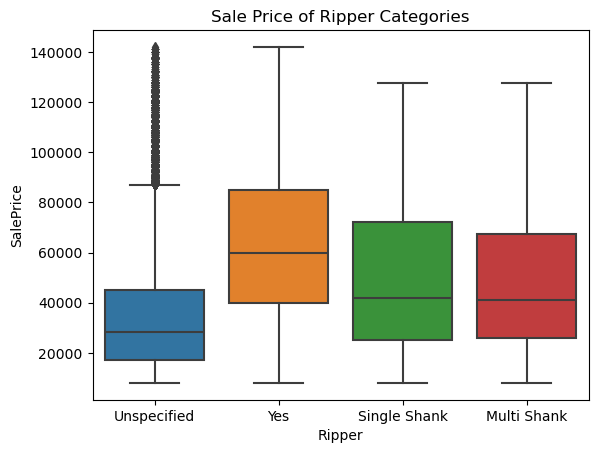

In [48]:
# Create a box plot to visualize prices among different ripper values

fig, ax = plt.subplots()
fig = sns.boxplot(data = df_copy, x = 'Ripper', y = 'SalePrice')
ax.set_title('Sale Price of Ripper Categories');

##### From the looks of this plot we can see a few things:
- There is about a 20,000 dollar difference between the sale price of bulldozers with a 'Yes' value and ones with a single or multi shank
- There is even more of a difference (roughly 30,000 dollar) between those that have a 'Yes' value and those that are unspecified or do not have a shank
- There is not much difference between in Sale Price between those that have a single shank and multi shank

##### While there is a statistical significance between the group means, this column is still largely null. 
- Let's create a correlation matrix as we did before to see how the correlation between this variable amd sale price compares to the other variables we have

In [49]:
# First we have to convert the categorical data to numeric, since we are mostly curious about the ripper column, we will only convert this

df_copy['Ripper Codes'] = df_copy['Ripper'].astype('category').cat.as_ordered()

In [50]:
# Now that we have created the Ripper Codes column as categoical we can get the category codes

df_copy['Ripper Codes'] = df_copy['Ripper Codes'].cat.codes+1 #add the +1 since cat codes encodes nulls as 0

In [51]:
# Find all the numeric dtypes to use in our corr matrix
numeric_cols = []

for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        numeric_cols.append(label)

print(numeric_cols)

['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'saleyear', 'salemonth', 'Ripper Codes']


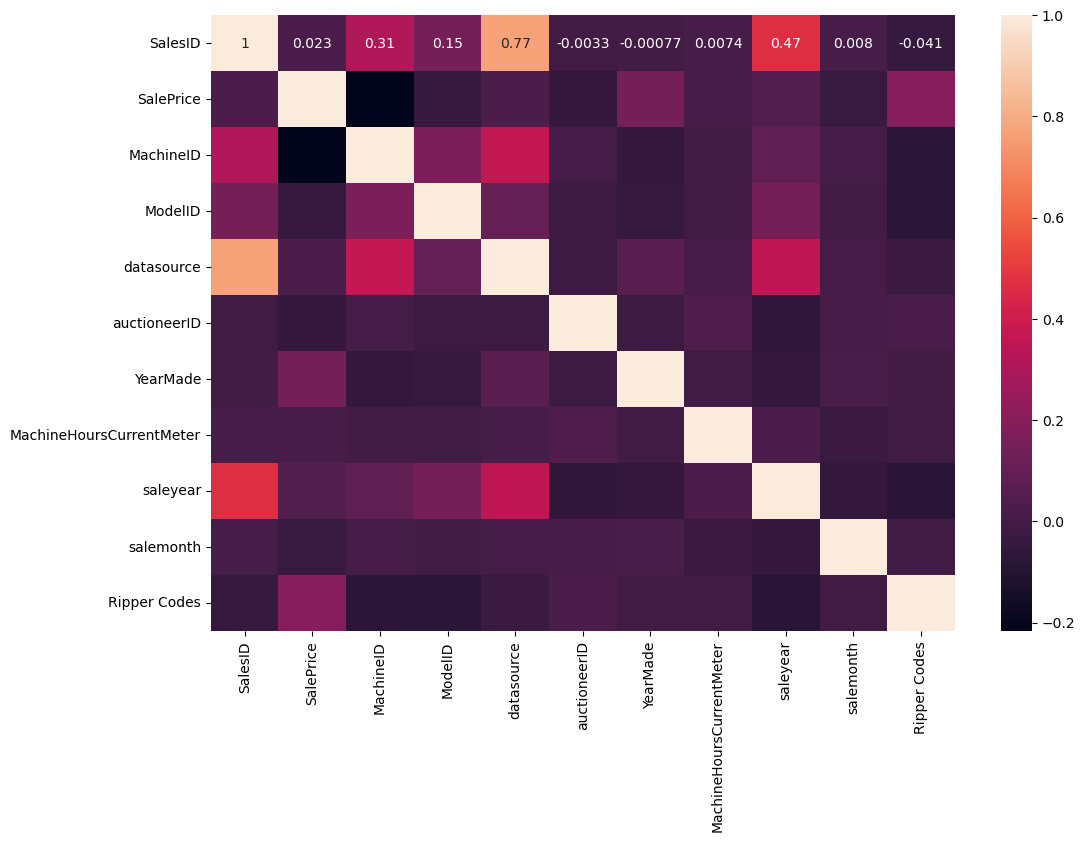

In [52]:
# Create correlation matrix
corr_mat = df_copy[numeric_cols].corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize = (12,8))
fig = sns.heatmap(data = corr_mat, annot = True)

##### From the above we can see that the Ripper Codes column has very little correlation to SalesPrice. For that reason we will drop both the Ripper Codes and Ripper columns

In [53]:
df_copy.drop(['Ripper', 'Ripper Codes'], axis = 1, inplace = True)

In [54]:
# Validate and check remaining nulls
df_copy.isna().sum() / len(df_copy) * 100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
saledate                     0.000000
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Ride_Control                62.992794
Transmission                54.444412
Hydraulics                  20.006155
Coupler                     46.527727
saleyear                     0.000000
salemonth                    0.000000
dtype: float

In [55]:
# Let's also inspect the Drive_System and Ride_Control column a bit since that is also just about 75% null and 63% null respectively

print(df_copy['Drive_System'].unique())
print(df_copy['Ride_Control'].unique())

[nan 'Four Wheel Drive' 'Two Wheel Drive' 'No' 'All Wheel Drive']
['None or Unspecified' nan 'No' 'Yes']


In [56]:
# As we can see this data is categorical, let's transform this in the same way we did with the Ripper column

df_copy['Drive_System_Codes'] = df_copy['Drive_System'].astype('category')

In [57]:
# Use the cat.codes function to return the categorical codes for this column 

df_copy['Drive_System_Codes'] = df_copy['Drive_System_Codes'].cat.codes+1

In [58]:
# Same process for the Ride_Control column

df_copy['Ride_Control_Codes'] = df_copy['Ride_Control'].astype('category')
df_copy['Ride_Control_Codes'] = df_copy['Ride_Control_Codes'].cat.codes+1

In [59]:
# Append these two new numeric cols to our numeric cols list

numeric_cols.extend(['Ride_Control_Codes','Drive_System_Codes'])

In [60]:
numeric_cols

['SalesID',
 'SalePrice',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleyear',
 'salemonth',
 'Ripper Codes',
 'Ride_Control_Codes',
 'Drive_System_Codes']

In [61]:
# Drop Ripper Codes from list since that column was dropped

numeric_cols.remove('Ripper Codes')

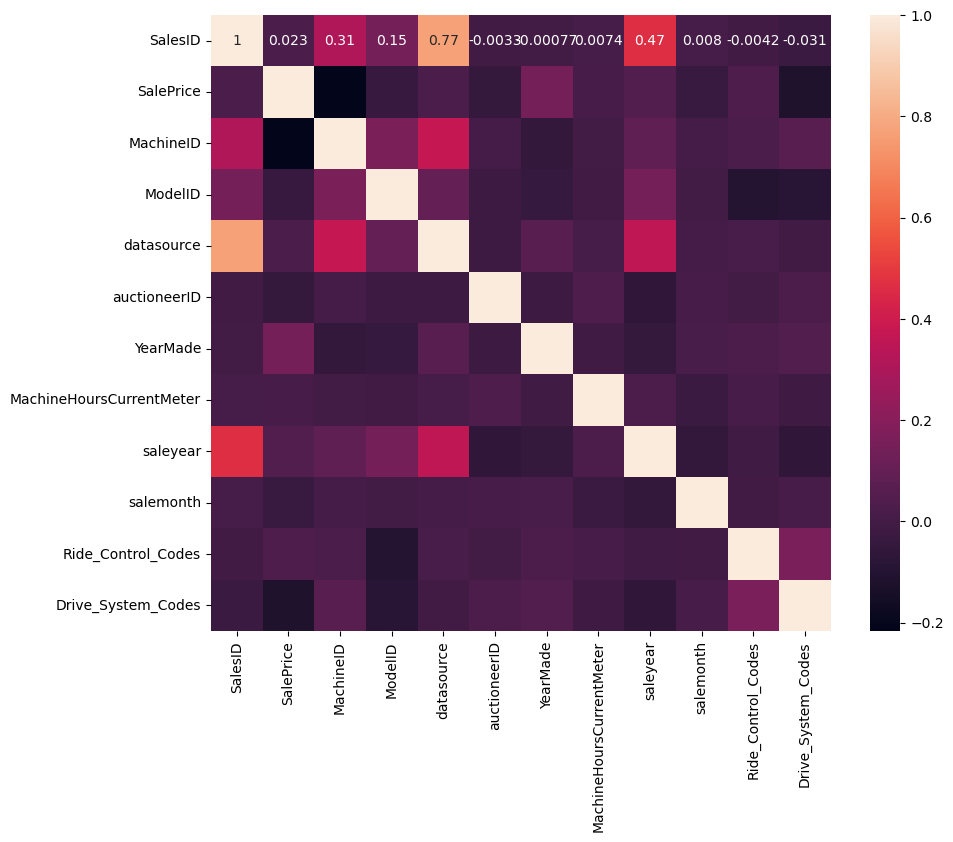

In [62]:
# Create another correlation matrix to inspect correlation before dropping

corr_mat = df_copy[numeric_cols].corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize = (10,8))
fig = sns.heatmap(corr_mat, annot = True)

In [63]:
# Neither have any type of correlation with the SalesPrice. We will proceed to drop these columns

df_copy.drop(['Drive_System_Codes', 'Ride_Control_Codes', 'Ride_Control', 'Drive_System'], axis = 1, inplace = True)

#### We will now fill the remaining numeric columns with the median

In [64]:
# Create a for loop to check if data type is numeric -- if it is, we will fill the nulls with the median

for label, content in df_copy.items():
    # Check if column is numeric
    if pd.api.types.is_numeric_dtype(content):
        #Check for nulls
        if pd.isnull(content).sum():
            # Add column to signify if there were nulls in that row
            df_copy[label+'is_null'] = pd.isnull(content)
            # Fill missing values with median
            df_copy[label] = content.fillna(content.median())
            
        

In [65]:
# Check nulls for each numeric col
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(f'{label} nulls:{df_copy[label].isna().sum()}')

SalesID nulls:0
SalePrice nulls:0
MachineID nulls:0
ModelID nulls:0
datasource nulls:0
auctioneerID nulls:0
YearMade nulls:0
MachineHoursCurrentMeter nulls:0
saleyear nulls:0
salemonth nulls:0
auctioneerIDis_null nulls:0
MachineHoursCurrentMeteris_null nulls:0


df_copy['auctioneerID'].isna().sum()

#### We will now get the categorical codes for all categorical columns

In [66]:
# Create for loop to check if data type is categorical -- if they are we will get the category codes

for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add column to signify if there were nulls in that row
        df_copy[label+'is_null'] = pd.isnull(content)
        # Get categorical codes and add 1 to prevent negatives
        df_copy[label] = pd.Categorical(content).codes+1
        

In [67]:
# Check nulls for each col -- since they are now all numeric we can run same code as above
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(f'{label} nulls:{df_copy[label].isna().sum()}')

SalesID nulls:0
SalePrice nulls:0
MachineID nulls:0
ModelID nulls:0
datasource nulls:0
auctioneerID nulls:0
YearMade nulls:0
MachineHoursCurrentMeter nulls:0
saledate nulls:0
fiModelDesc nulls:0
fiBaseModel nulls:0
fiSecondaryDesc nulls:0
ProductSize nulls:0
fiProductClassDesc nulls:0
state nulls:0
ProductGroup nulls:0
ProductGroupDesc nulls:0
Enclosure nulls:0
Forks nulls:0
Transmission nulls:0
Hydraulics nulls:0
Coupler nulls:0
saleyear nulls:0
salemonth nulls:0
auctioneerIDis_null nulls:0
MachineHoursCurrentMeteris_null nulls:0
saledateis_null nulls:0
fiModelDescis_null nulls:0
fiBaseModelis_null nulls:0
fiSecondaryDescis_null nulls:0
ProductSizeis_null nulls:0
fiProductClassDescis_null nulls:0
stateis_null nulls:0
ProductGroupis_null nulls:0
ProductGroupDescis_null nulls:0
Enclosureis_null nulls:0
Forksis_null nulls:0
Transmissionis_null nulls:0
Hydraulicsis_null nulls:0
Coupleris_null nulls:0


In [68]:
# Turn boolean columns into categorical code columns

for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

### Let's now check for high multicollinearity between columns before splitting our data for modelling

In [69]:
df_copy.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Enclosure', 'Forks', 'Transmission', 'Hydraulics', 'Coupler',
       'saleyear', 'salemonth', 'auctioneerIDis_null',
       'MachineHoursCurrentMeteris_null', 'saledateis_null',
       'fiModelDescis_null', 'fiBaseModelis_null', 'fiSecondaryDescis_null',
       'ProductSizeis_null', 'fiProductClassDescis_null', 'stateis_null',
       'ProductGroupis_null', 'ProductGroupDescis_null', 'Enclosureis_null',
       'Forksis_null', 'Transmissionis_null', 'Hydraulicsis_null',
       'Coupleris_null'],
      dtype='object')

In [70]:
# To do this we will use the Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# calulate VIF for each factor except our target (SalePrice)
df_vif = df_copy.drop(['SalePrice','auctioneerIDis_null',
       'MachineHoursCurrentMeteris_null', 'saledateis_null',
       'fiModelDescis_null', 'fiBaseModelis_null', 'fiSecondaryDescis_null',
       'ProductSizeis_null', 'fiProductClassDescis_null', 'stateis_null',
       'ProductGroupis_null', 'ProductGroupDescis_null', 'Enclosureis_null',
       'Forksis_null', 'Transmissionis_null', 'Hydraulicsis_null',
       'Coupleris_null'], axis = 1)
vif_data = pd.DataFrame()
vif_data['Feature'] = df_vif.columns
vif_data['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif_data)

                     Feature         VIF
0                    SalesID   12.837970
1                  MachineID   10.310396
2                    ModelID    2.581378
3                 datasource  523.055636
4               auctioneerID    1.152337
5                   YearMade   49.004125
6   MachineHoursCurrentMeter    1.012704
7                   saledate    9.478130
8                fiModelDesc  262.172118
9                fiBaseModel  226.054958
10           fiSecondaryDesc    2.542822
11               ProductSize    5.323978
12        fiProductClassDesc   22.368187
13                     state    3.350052
14              ProductGroup         inf
15          ProductGroupDesc         inf
16                 Enclosure    5.338925
17                     Forks    4.838508
18              Transmission   18.353913
19                Hydraulics    6.336899
20                   Coupler   21.744306
21                  saleyear  495.610102
22                 salemonth    4.499748


#### Based on the above we can see we have a few features with high Variance Inflation Factors
- We will drop these beginning with the highest 

In [71]:
# This cell will be run a couple times as we retest our VIF as we drop some features

# calulate VIF for each factor except our target (SalePrice)
df_vif = df_vif.drop(['ProductGroupDesc', 'Coupler'], axis = 1)
vif_data = pd.DataFrame()
vif_data['Feature'] = df_vif.columns
vif_data['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif_data)

                     Feature         VIF
0                    SalesID   12.835920
1                  MachineID   10.174507
2                    ModelID    2.578650
3                 datasource  521.957166
4               auctioneerID    1.152289
5                   YearMade   49.001866
6   MachineHoursCurrentMeter    1.012654
7                   saledate    9.451357
8                fiModelDesc  261.923145
9                fiBaseModel  225.788811
10           fiSecondaryDesc    2.528981
11               ProductSize    5.303672
12        fiProductClassDesc   20.750511
13                     state    3.349614
14              ProductGroup   52.987104
15                 Enclosure    5.290621
16                     Forks    4.107410
17              Transmission    8.738490
18                Hydraulics    5.790496
19                  saleyear  492.677488
20                 salemonth    4.499622


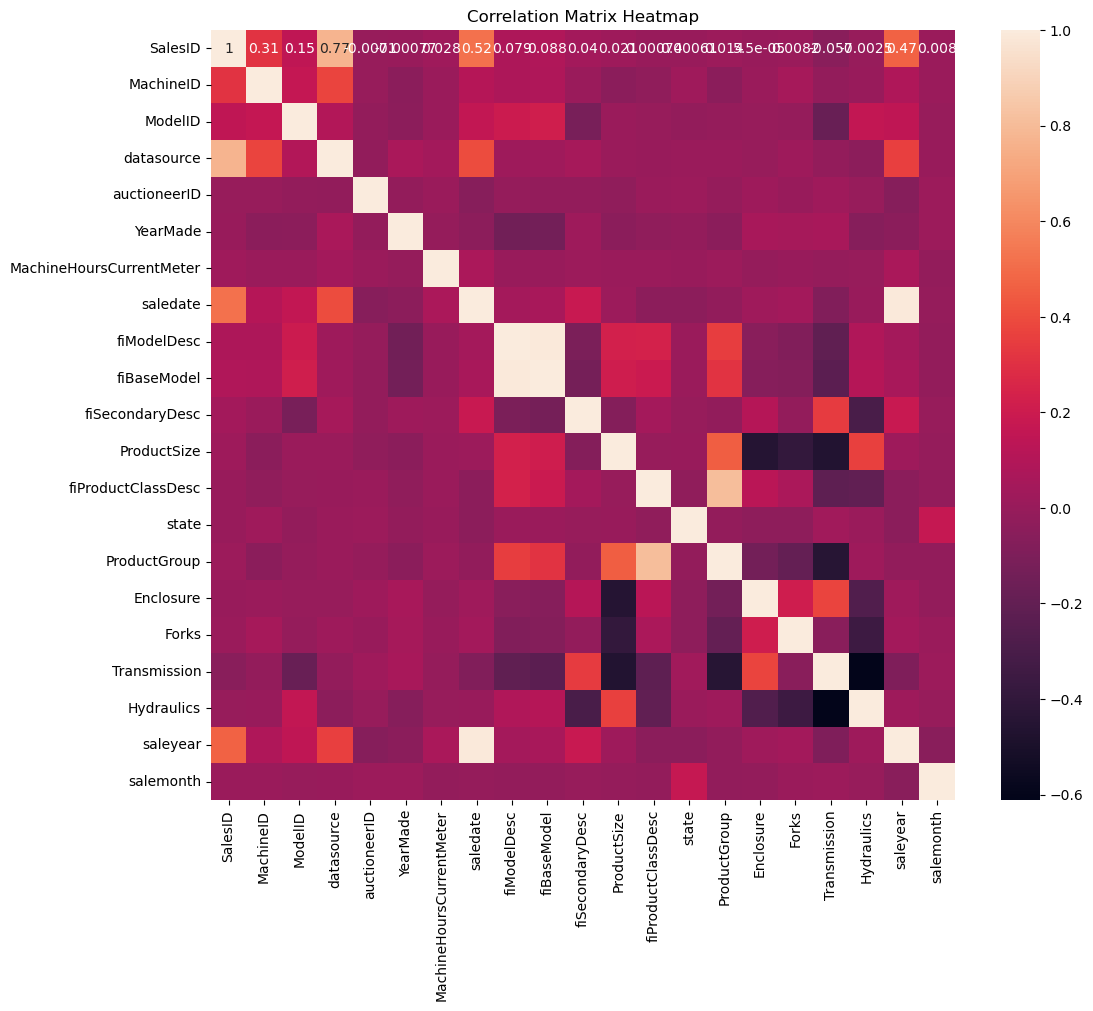

In [72]:
# Based on the remaining columns let's do some bivariate analysis using a correlation matrix to see which features are highly correlated

corr_mat = df_vif.corr()

fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(corr_mat, annot = True)
plt.title('Correlation Matrix Heatmap')
plt.show()

### After dropping some of the features that demonstrated high collinearity we can now continue with splitting our data

In [73]:
# We will be using the same columns that we have in our df_vif + the saleprice column for modelling since we have removed features with high collinearity from that dataset

df_vif.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'saledate', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'ProductSize', 'fiProductClassDesc',
       'state', 'ProductGroup', 'Enclosure', 'Forks', 'Transmission',
       'Hydraulics', 'saleyear', 'salemonth'],
      dtype='object')

In [86]:
df_new = df_copy[['SalePrice','SalesID', 'MachineID', 'ModelID', 'auctioneerID', 'YearMade',
       'MachineHoursCurrentMeter', 'saledate', 'fiBaseModel',
       'fiSecondaryDesc', 'ProductSize', 'state', 'ProductGroup', 'Enclosure',
       'Forks', 'Transmission', 'Hydraulics', 'saleyear', 'salemonth']]

In [87]:
# Sort the data by saledate before dropping that column
df_new.sort_values(by = 'saledate', inplace = True)

In [76]:
# validate
df_new.head()

,SalePrice,SalesID,MachineID,ModelID,auctioneerID,YearMade,MachineHoursCurrentMeter,saledate,fiBaseModel,fiSecondaryDesc,ProductSize,state,ProductGroup,Enclosure,Forks,Transmission,Hydraulics,saleyear,salemonth
205615,9500.0,1646770,1126363,8434,18.0,1974,0.0,1,1744,0,4,44,5,6,0,3,1,1989,1
274835,14000.0,1821514,1194089,10150,99.0,1980,0.0,2,559,0,0,9,6,6,1,0,1,1989,1
141296,50000.0,1505138,1473654,4139,99.0,1978,0.0,2,713,59,2,9,5,6,0,8,1,1989,1
212552,16000.0,1671174,1327630,8591,99.0,1980,0.0,2,558,0,0,9,6,1,1,0,1,1989,1
62755,22000.0,1329056,1336053,4089,99.0,1984,0.0,2,683,21,0,9,5,6,0,8,1,1989,1


In [88]:
# Drop saledate since we have saleyear and salemonth
df_new.drop('saledate', axis = 1)

,SalePrice,SalesID,MachineID,ModelID,auctioneerID,YearMade,MachineHoursCurrentMeter,fiBaseModel,fiSecondaryDesc,ProductSize,state,ProductGroup,Enclosure,Forks,Transmission,Hydraulics,saleyear,salemonth
205615,9500.0,1646770,1126363,8434,18.0,1974,0.0,1744,0,4,44,5,6,0,3,1,1989,1
274835,14000.0,1821514,1194089,10150,99.0,1980,0.0,559,0,0,9,6,6,1,0,1,1989,1
141296,50000.0,1505138,1473654,4139,99.0,1978,0.0,713,59,2,9,5,6,0,8,1,1989,1
212552,16000.0,1671174,1327630,8591,99.0,1980,0.0,558,0,0,9,6,1,1,0,1,1989,1
62755,22000.0,1329056,1336053,4089,99.0,1984,0.0,683,21,0,9,5,6,0,8,1,1989,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,16000.0,6302984,1915521,5266,99.0,2001,0.0,690,50,0,5,5,6,0,8,1,2012,4
412476,6000.0,6324811,1919104,19330,99.0,2004,0.0,84,0,0,5,3,6,1,0,4,2012,4
411927,16000.0,6313029,1918416,17244,99.0,2004,0.0,203,59,5,5,4,3,0,0,4,2012,4
407124,55000.0,6266251,509560,3357,99.0,1993,0.0,19,59,0,5,2,6,0,5,5,2012,4


In [89]:
# Split data into X ( independant variables )& y ( dependant variable )
X = df_new.drop('SalePrice', axis = 1)
y = df_new.SalePrice

In [90]:
# Import train test split
from sklearn.model_selection import train_test_split

# Split our data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Check shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(330158, 18)
(330158,)
(82540, 18)
(82540,)


### We will now begin experimenting with modelling. To start we will begin with a simple regression model

In [80]:
# Import linear regression

from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

In [81]:
# Fit the model to training data

lr_model.fit(X_train, y_train)

LinearRegression()

In [82]:
lr_model.score(X_train, y_train)

0.2290562213981464

#### Based on the above R-squared score we can see our linear regression model is very weak

In [83]:
# Make predictions on our test data

lr_model_preds = lr_model.predict(X_test)

In [84]:
# Evaluate the model

# Import our evaluation metrics

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [85]:
# Create a function that we can call to evaluate the various models

def evaluate_reg_model(y_true, y_pred):
    print(f'R-Squared Score: {r2_score(y_true, y_pred)}')
    print(f'Mean Squared Error: {mean_squared_error(y_true, y_pred)}')
    print(f'Mean Absolute Error: {mean_absolute_error(y_true, y_pred)}')
    print(f'Median Absolute Error: {median_absolute_error(y_true, y_pred)}')

In [79]:
# Evaluate the linear regression model
evaluate_reg_model(y_test, lr_model_preds)

R-Squared Score: 0.23005790621956967
Mean Squared Error: 412620367.1224922
Mean Absolute Error: 14847.678778081894
Median Absolute Error: 11041.927626489778


#### We have a very low R-Squred score on our test data as well. This could be due to a couple issues.
- First we will inspect the linearity of our features using scatter plots as well as a residual plot

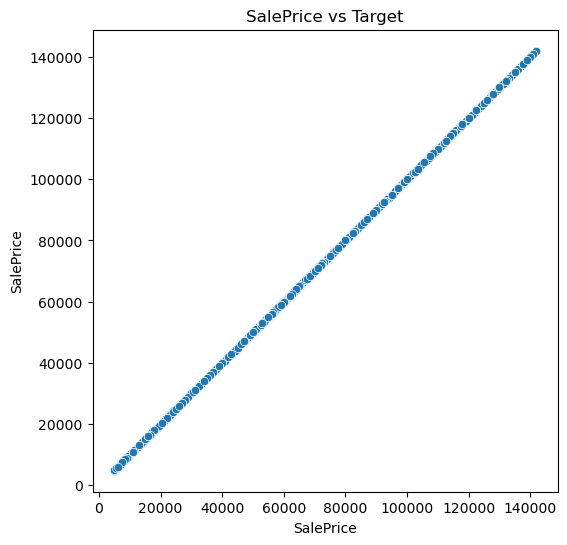

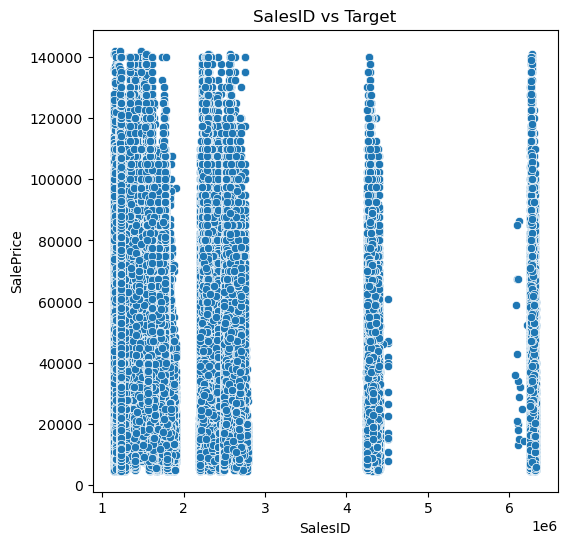

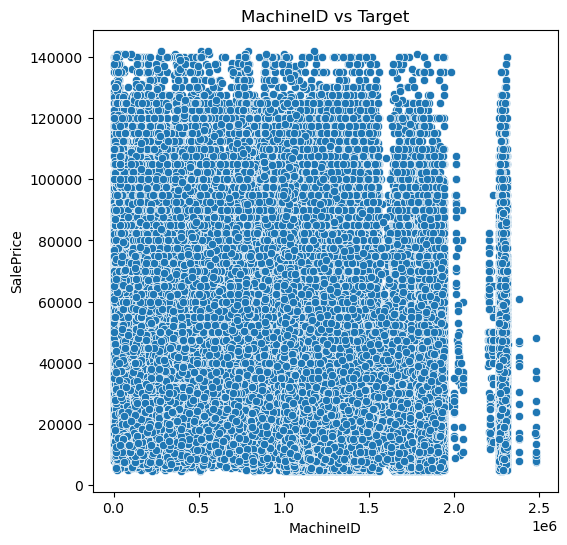

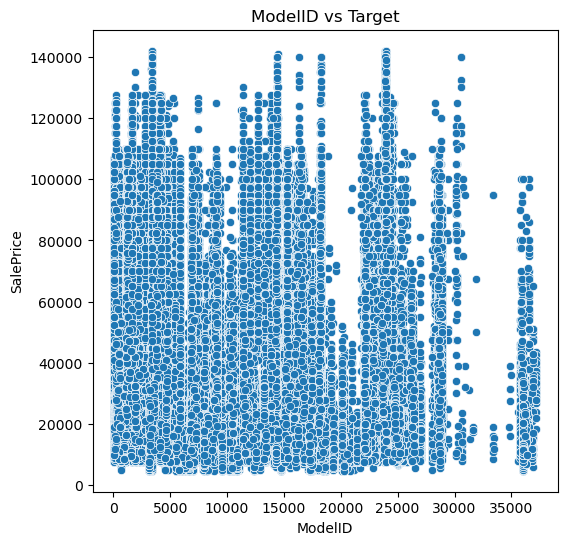

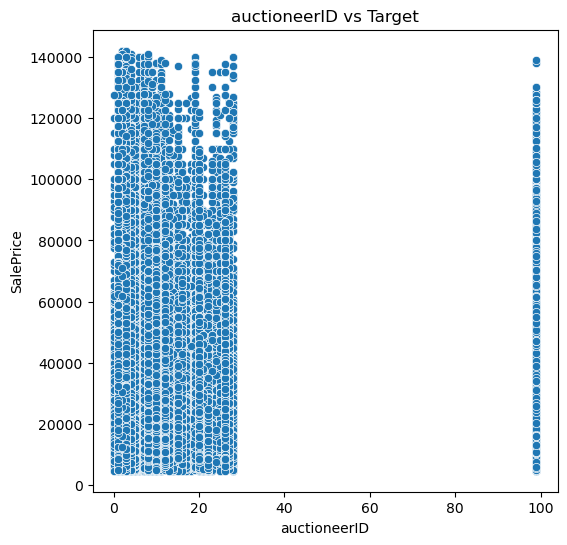

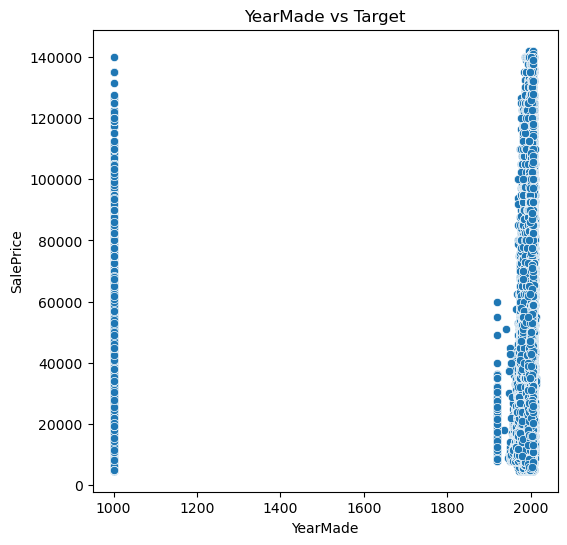

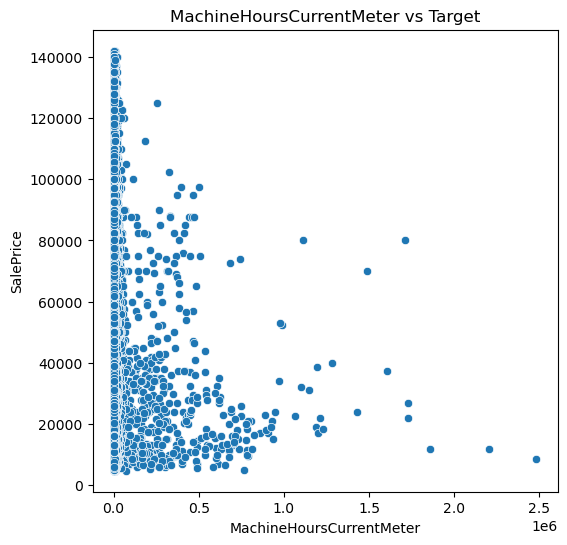

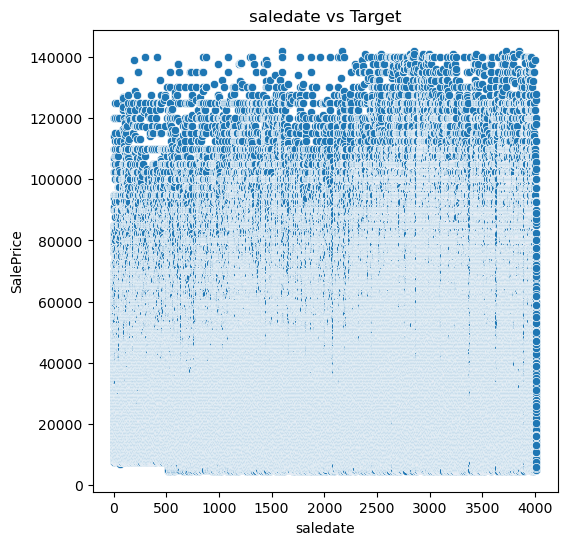

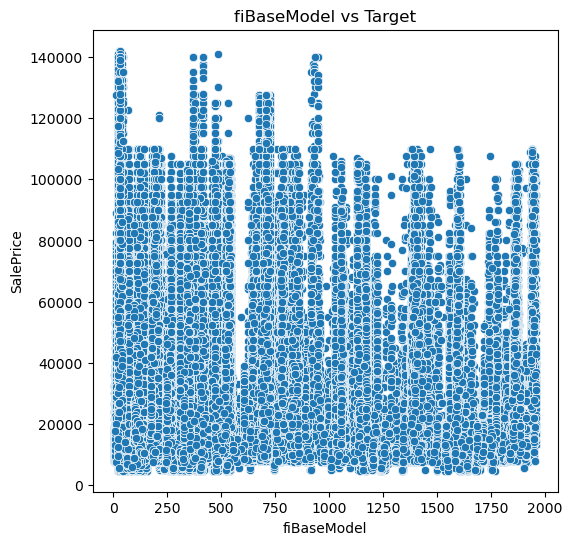

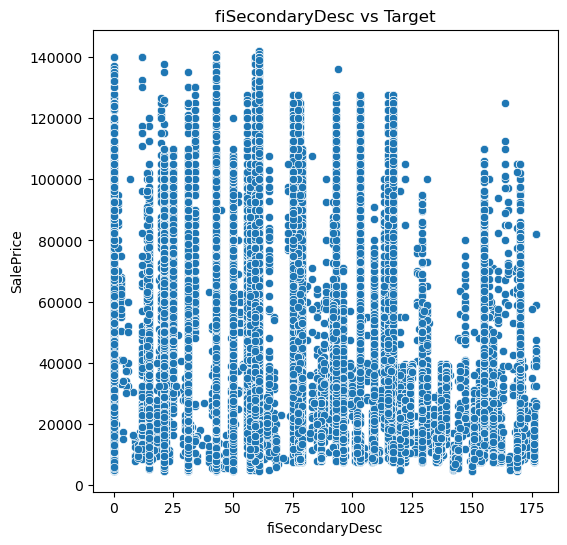

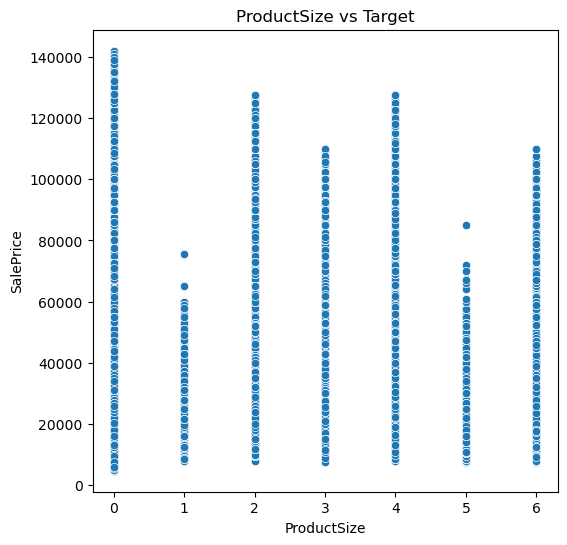

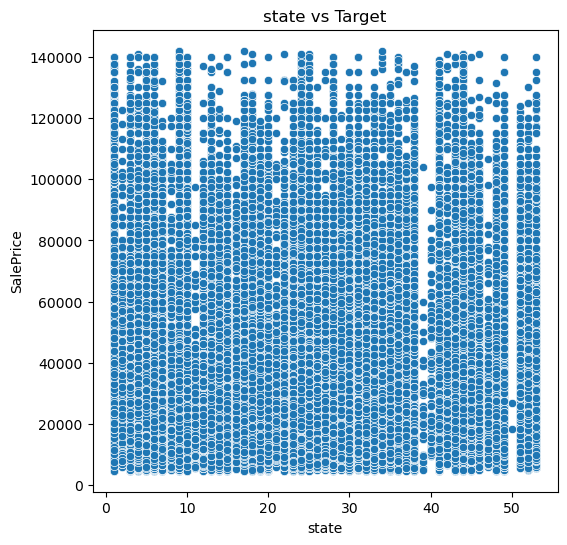

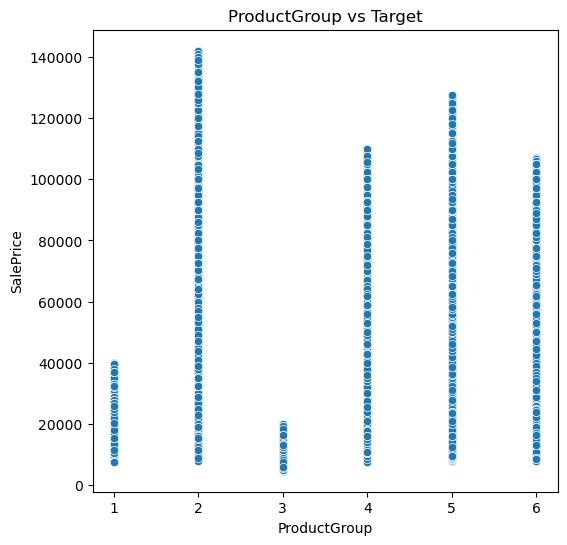

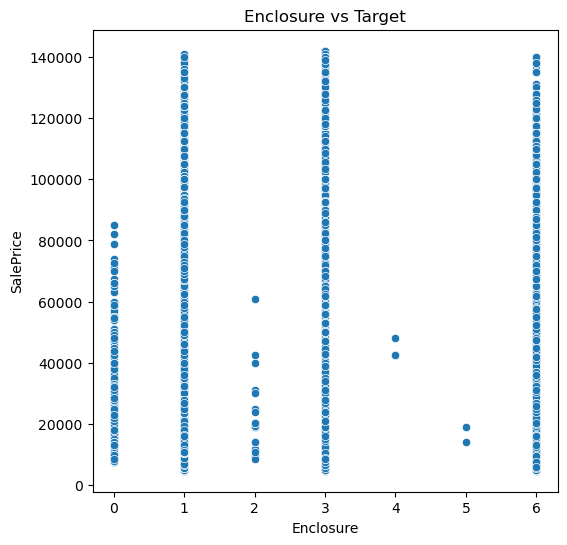

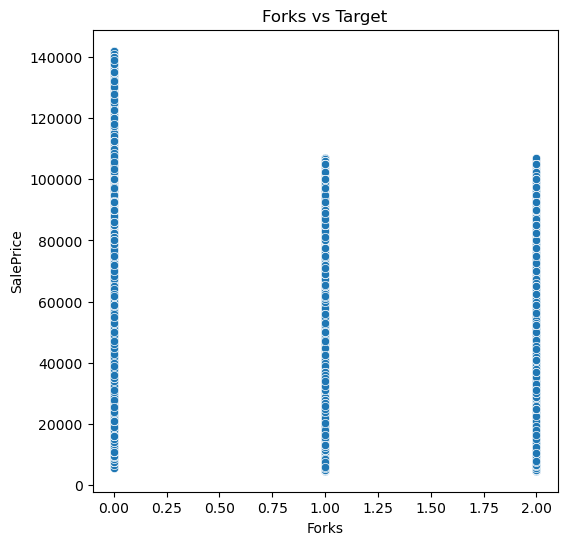

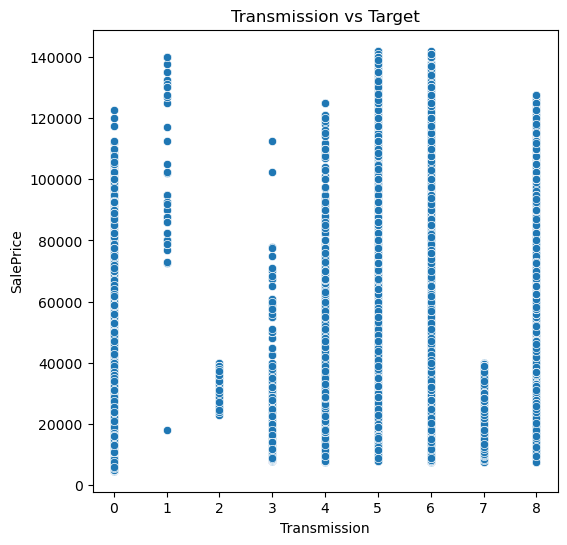

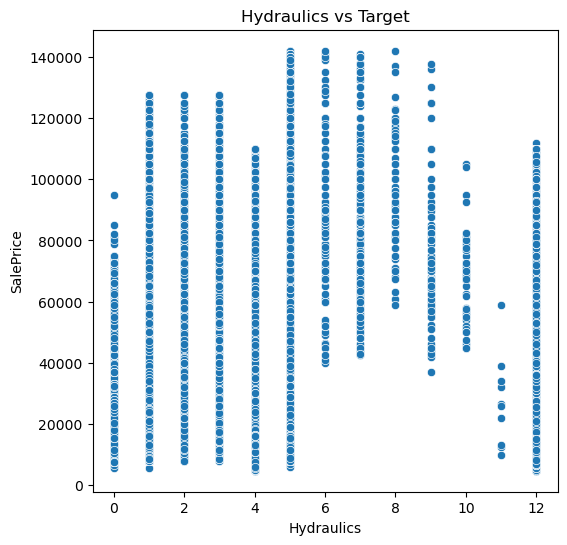

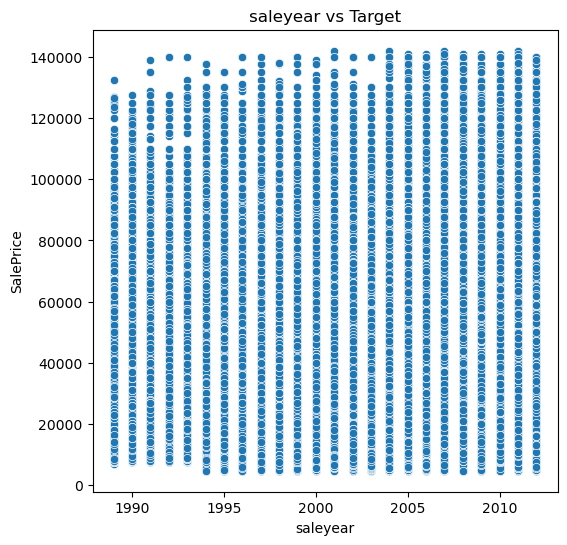

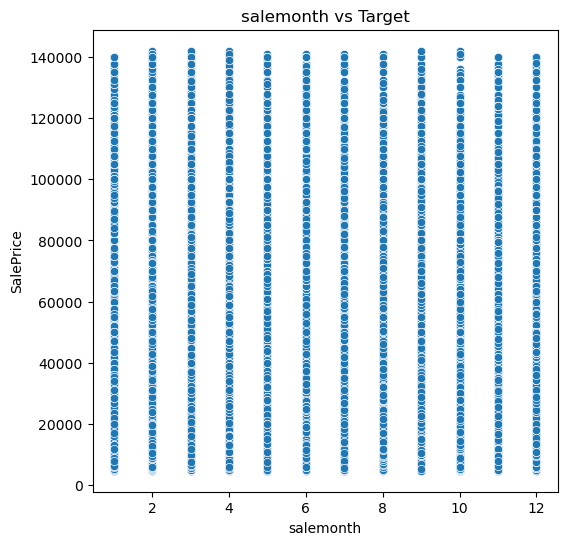

In [80]:
# Plot scatterplot of each feature vs the target variable

for column in df_new.columns:
    plt.figure(figsize = (6,6))
    sns.scatterplot(x = df_new[column], y = df_new['SalePrice'])
    plt.title(f'{column} vs Target')
    plt.show()

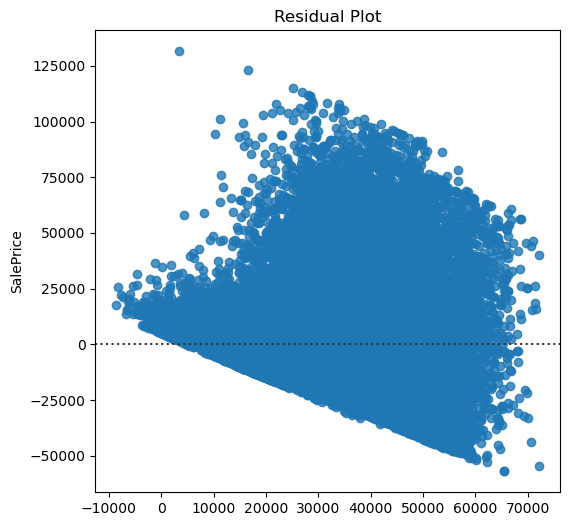

In [81]:
# Let's now plot the residuals (difference between our predicted values and true values)

residuals = y_test - lr_model_preds

plt.figure(figsize=(6,6))
sns.residplot(x= lr_model_preds, y = residuals)
plt.title('Residual Plot')
plt.show()

#### From the residual plot we can see that our residuals are not random and therefore may point out that the relationship between features and target variable may not be linear

### Let's now try to use a RandomForestRegressor
- Since some of our data is categorical a RandomForest model may work better

In [91]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate a RandomForestRegressor
rf_model = RandomForestRegressor()

# Fit the RandomForest model to our training data
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [92]:
# Make predictions on RandomForest model
rf_preds = rf_model.predict(X_test)

# Evaluate the base RandomForest model
evaluate_reg_model(y_test, rf_preds)

R-Squared Score: 0.9047987228027933
Mean Squared Error: 51019402.971938156
Mean Absolute Error: 4450.581123116064
Median Absolute Error: 2582.5


#### Based on these metrics (particularly the R-sqaured score) we can see this model performs much better than our simple linear regression

##### We can probbably improve this model even more by hyperparameter tuning using GridSearchCV

In [93]:
# Drop Sale date
X.drop('saledate', axis = 1, inplace = True)

In [99]:
# Import Grid Search CV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [101]:
# Define our hyperparameters to tune
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, 
                                 n_iter = 100, cv = 3, n_jobs = -1, verbose = 2, 
                                 scoring = ['r2', 'neg_mean_squared_error'], refit = 'r2',
                                 random_state = 42, return_train_score = True)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.7min
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  45.8s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.6min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimato

In [104]:
# Check the best parameters for our RandomizedSearch Model
random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': False}

[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  49.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  47.3s


In [107]:
# Get r2 scores on training data
random_search.score(X_train, y_train)

0.9999996361227936

#### Let's now make predictions on the test data using our randomsearch model

In [108]:
# Make predictions
rs_preds = random_search.predict(X_test)

# Score the predictions using the function we defined earlier
evaluate_reg_model(y_test, rs_preds)

R-Squared Score: 0.9100680173065198
Mean Squared Error: 48195530.56625024
Mean Absolute Error: 4321.538568240123
Median Absolute Error: 2519.5


#### Based on these evaluations we can see our randomized search model performed only slightly better than our base randomforest regressor. 

##### We can now look into some other ways to improve our model, such as dropping irrelevant/non-predictive features

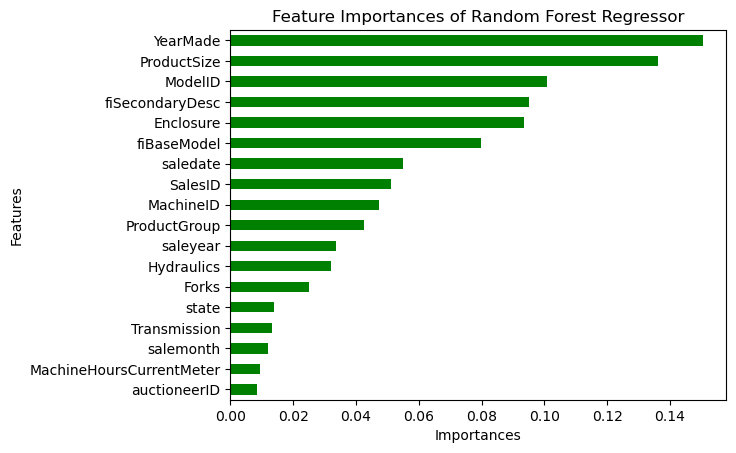

In [133]:
# Let's start by checking the feature importances of our model

feature_importances = pd.Series(random_search.best_estimator_.feature_importances_, X_train.columns).sort_values(ascending = True)
feature_importances.plot.barh(color = 'green')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importances of Random Forest Regressor')
plt.show()


In [137]:
# Create a random variable 
X_train['RANDOM'] = np.random.RandomState(42).randn(X_train.shape[0])

In [139]:
# Fit model with new variable

random_search_with_variable = random_search.best_estimator_.fit(X_train, y_train)

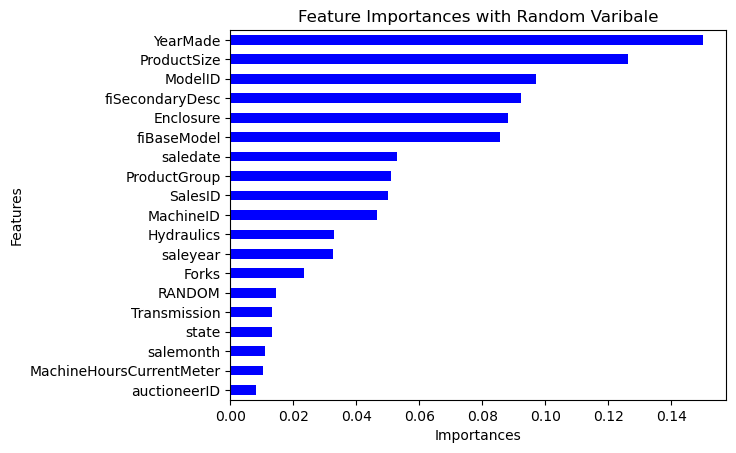

In [140]:
# Plot importances with new random variable

feat_import_w_random_var = pd.Series(random_search_with_variable.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_import_w_random_var.plot.barh(color = 'blue')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importances with Random Varibale')
plt.show()

#### Our RANDOM variable ranking towards the bottom of our feature importances is a good sign. We will drop any variables that rank worse than the RANDOM variable.

- We are goimg to keep sale month and instead frop saledate.. The importance of sale date may be inflated due to high value counts in that variable

In [150]:
# Create a variable to store the columns we will drop before refitting since we will need to also drop these columns from our test set
# We will also drop SalesID as that has no predictive value
nonpredictive_variables = ['Transmission', 'state', 'MachineHoursCurrentMeter', 'auctioneerID', 'SalesID', 'RANDOM', 'saledate']


# Refit the model

random_search_model2 = random_search.best_estimator_.fit(X_train.drop(nonpredictive_variables, axis = 1), y_train)

In [152]:
# Get predictions on test data using our new model
rs_preds_2 = random_search_model2.predict(X_test.drop(['Transmission', 'state', 'MachineHoursCurrentMeter', 'auctioneerID', 'SalesID', 'saledate'], axis = 1))

# Score the model
evaluate_reg_model(y_test, rs_preds_2)

R-Squared Score: 0.8972670017342748
Mean Squared Error: 55055734.45382569
Mean Absolute Error: 4659.204135472835
Median Absolute Error: 2759.0


#### We can see that our model's r2 metric is worse than that of the baseline model.
#### However, we know that any time you add a independant variable to a model the r2 metric will increase by deafult, so let's check our Adjusted r2

In [157]:
# Calculate adjusted r2 of our baseline model
1 - (1 - rf_model.score(X_test, y_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1]-1)

0.9047779569009071

In [162]:
# Calculate adjusted r2 of our random_search_model2

variables_to_drop = ['Transmission', 'state', 'MachineHoursCurrentMeter', 'auctioneerID', 'SalesID', 'saledate']

1 - (1 - random_search_model2.score(X_test.drop(variables_to_drop, axis = 1), y_test)) * (len(y_test) - 1) / (len(y_test) - X_test.drop(variables_to_drop, axis = 1).shape[1]-1)

0.8972520636415392

##### As we can see our adjusted r2 of our newest model is worse than that of our baseline model, we can conclude that our random_search model is the best of the ones we have tested and the model we should continue with